In [29]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from datetime import datetime
import json

# --- Load JSON Datasets ---
user_data = pd.read_json('user_data.json')
landlord_data = pd.read_json('landlord_data.json')
history_data = pd.read_json('history_data.json')
private_parking_data = pd.read_json('private_parking.json')
public_parking_data = pd.read_json('public_parking.json')

# --- Process History Data ---
# Merge history_data with private_parking_data to obtain price information.
merged_history = pd.merge(
    history_data,
    private_parking_data[['private_id', 'price_per_hour']],
    left_on='parking_id',
    right_on='private_id',
    how='left'
)
merged_history['price'] = merged_history['price_per_hour']

# Convert "distance" from a string like "40.78 KM" to a numeric value.
merged_history['distance'] = merged_history['distance'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)

# --- JSON Template for a Single Temporary Candidate Record ---
temp_data_template = {
    "user_id": "UID76467",
    "parking_id": "PRI80775",
    "rating": 4.2,        # An estimated or aggregated satisfaction score
    "price": 1.45,        # Current price per hour from parking data
    "distance": 3.2,      # Real-time computed distance (in km)
    "datetime": "2023-08-01T10:00:00"  # Time of the parking search/request
}
with open('temp_data_template.json', 'w') as f:
    json.dump(temp_data_template, f, indent=4)

# --- Create Temporary Candidate Data from Private Parking Data ---
temp_data = private_parking_data.copy()
temp_data = temp_data.rename(columns={"private_id": "parking_id", "price_per_hour": "price"})
if "rating" not in temp_data.columns:
    temp_data["rating"] = 4.0  # Set a default rating if missing.
# For demonstration, generate a random distance (in practice, compute using user and parking coordinates).
temp_data["distance"] = np.random.uniform(1, 10, size=len(temp_data))
# Set current datetime for candidate records.
temp_data["datetime"] = datetime.now().isoformat()

# --- Function to Train KMeans on Historical Data ---
def train_kmeans_on_history(history_df, num_clusters=5):
    """
    Trains a KMeans model using features from the history data.
    Expected features: 'rating', 'price', 'distance'
    """
    # Extract and clean features.
    features = history_df[['rating', 'price', 'distance']].copy()
    features['rating'] = pd.to_numeric(features['rating'], errors='coerce')
    features['price'] = pd.to_numeric(features['price'], errors='coerce')
    features['distance'] = pd.to_numeric(features['distance'], errors='coerce')
    features.fillna(features.mean(), inplace=True)
    
    # Train the KMeans clustering model using numpy arrays to avoid feature name warnings.
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(features.to_numpy())
    
    # Optionally, store the computed cluster labels in the history data.
    history_df['cluster'] = kmeans.labels_
    return kmeans

# --- Function to Recommend Parking Using Temporary Data ---
def recommend_parking_with_kmeans_temp(user_id, history_df, temp_data_df, kmeans_model):
    """
    Given a user_id, historical parking data, and new temporary candidate data,
    this function computes the user's preference vector from history, determines
    the corresponding cluster, assigns clusters to the temporary data, and returns
    recommended parking candidates from the same cluster.
    """
    # Get the user's historical records.
    user_history = history_df[history_df['user_id'] == user_id]
    if user_history.empty:
        print(f"No history available for user {user_id}.")
        return pd.DataFrame()  # No recommendations available.
    
    # Compute average user preferences from history.
    avg_rating = user_history['rating'].mean()
    avg_price = user_history['price'].mean()
    avg_distance = user_history['distance'].mean()
    user_vector = np.array([[avg_rating, avg_price, avg_distance]])
    
    # Predict the cluster for the user's preferences.
    user_cluster = kmeans_model.predict(user_vector)[0]
    
    # Assign clusters to the new temporary candidate data using numpy arrays.
    temp_features = temp_data_df[['rating', 'price', 'distance']].copy()
    predicted_clusters = kmeans_model.predict(temp_features.to_numpy())
    temp_data_df = temp_data_df.copy()  # Avoid SettingWithCopyWarning
    temp_data_df['cluster'] = predicted_clusters
    
    # Filter and sort the temporary data by matching cluster and (for example) by distance.
    recommended = temp_data_df[temp_data_df['cluster'] == user_cluster].copy()
    recommended = recommended.sort_values('distance').head(5)
    
    return recommended

# --- Train the KMeans Model Using Processed Historical Data ---
kmeans_model = train_kmeans_on_history(merged_history, num_clusters=3)

# --- Get Recommendations for a Specific User ---
# IMPORTANT: Make sure the user_id exists in your history data.
# For example, if your history sample contains user "UID42085", use that.
user_id = "UID76467"  # Change this if needed.
recommendations = recommend_parking_with_kmeans_temp(user_id, merged_history, temp_data, kmeans_model)

print("Recommended parking options:")
print(recommendations)


Recommended parking options:
Empty DataFrame
Columns: [parking_id, name, address, latitude, longitude, price, capacity, available_space, special_access, landlord_id, opening_time, city, note_area, key_access_info, rating, distance, datetime, cluster]
Index: []


No history available for user UID70455
No recommendations available for user UID70455
No history available for user UID71736
No recommendations available for user UID71736


c:\Users\Tristan\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


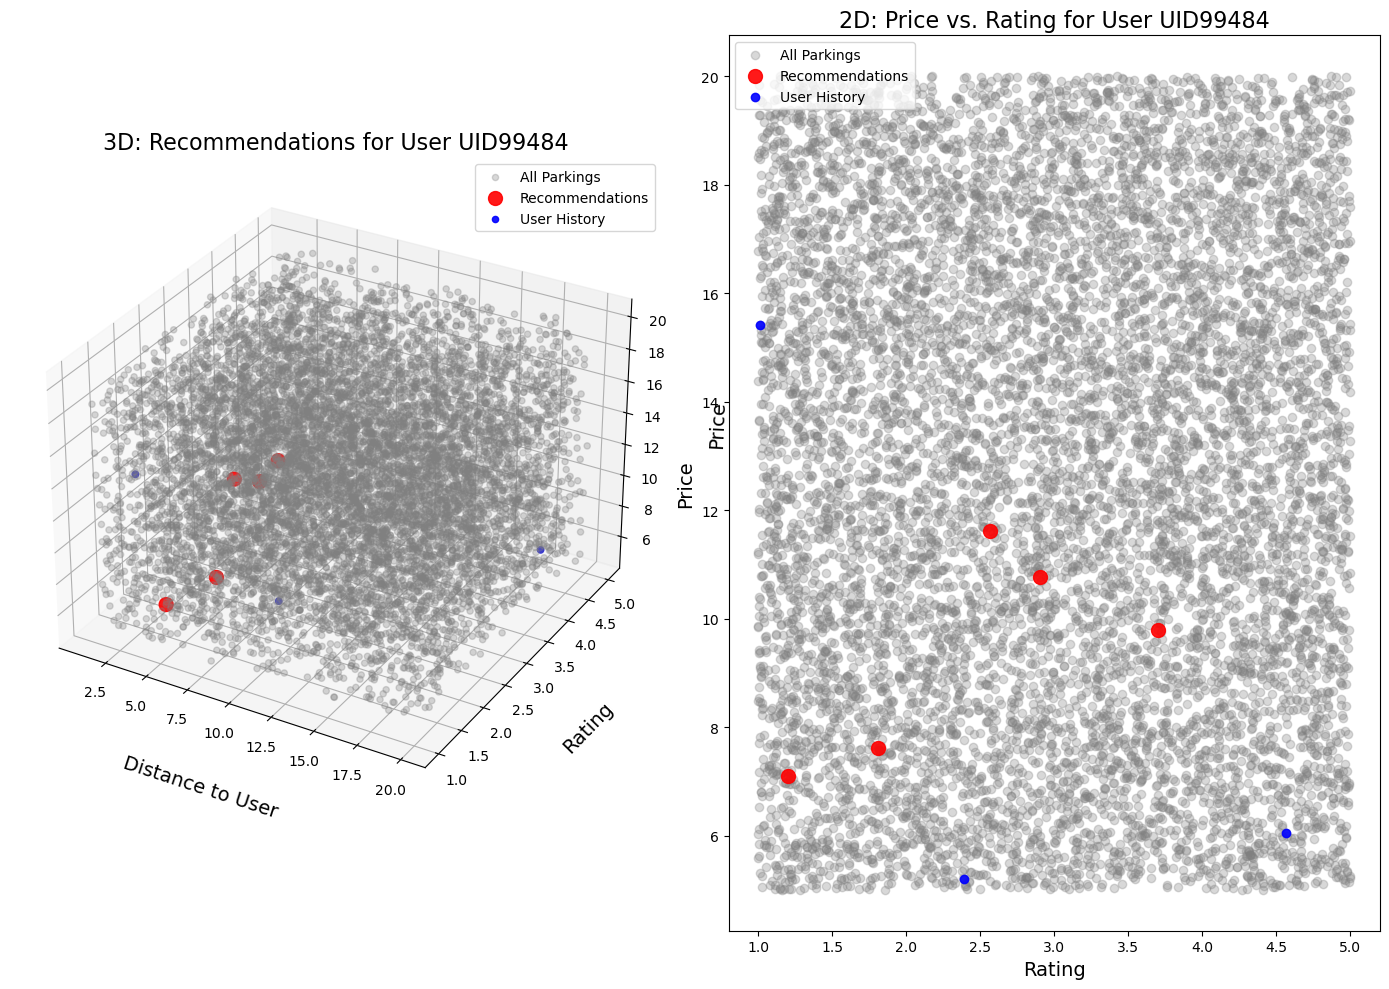

In [30]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Ensure Required Columns in Parking Data with Rating
def ensure_required_columns(parking_df):
    required_columns = ['price', 'rating', 'distance']
    for column in required_columns:
        if column not in parking_df.columns:
            if column == 'price':
                parking_df[column] = np.random.uniform(5, 20, size=len(parking_df))
            elif column == 'rating':
                parking_df[column] = np.random.uniform(1.0, 5.0, size=len(parking_df))  # Random ratings from 1 to 5
            elif column == 'distance':
                parking_df[column] = np.random.uniform(1.0, 20.0, size=len(parking_df))
        else:
            # Convert to numeric and handle errors
            parking_df[column] = pd.to_numeric(parking_df[column], errors='coerce')
            parking_df[column].fillna(parking_df[column].mean(), inplace=True)
    return parking_df

# Load the datasets from JSON files
user_data = pd.read_json('user_data.json')
landlord_data = pd.read_json('landlord_data.json')
history_data = pd.read_json('history_data.json')
private_parking_data = pd.read_json('private_parking.json')
public_parking_data = pd.read_json('public_parking.json')

# Update private_parking_data to ensure required columns
private_parking_data = ensure_required_columns(private_parking_data)

# K-Means Clustering Algorithm with Rating
def recommend_parking_with_kmeans(user_id, history_df, parking_df, num_clusters=5):
    # Filter user history
    user_history = history_df[history_df["user_id"] == user_id]

    if user_history.empty:
        print(f"No history available for user {user_id}")
        return pd.DataFrame()  # Return an empty DataFrame if no history is available

    # Extract parking features
    parking_features = parking_df[['price', 'rating', 'distance']]
    
    # Train K-Means Model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    parking_df['cluster'] = kmeans.fit_predict(parking_features)

    # Compute user preferences based on parking IDs in user history
    avg_price = parking_df.loc[parking_df["private_id"].isin(user_history["parking_id"]), "price"].mean()
    avg_rating = parking_df.loc[parking_df["private_id"].isin(user_history["parking_id"]), "rating"].mean()
    avg_distance = parking_df.loc[parking_df["private_id"].isin(user_history["parking_id"]), "distance"].mean()

    # Replace NaN preferences with column means
    avg_price = avg_price if not pd.isna(avg_price) else parking_features['price'].mean()
    avg_rating = avg_rating if not pd.isna(avg_rating) else parking_features['rating'].mean()
    avg_distance = avg_distance if not pd.isna(avg_distance) else parking_features['distance'].mean()

    user_preferences = np.array([avg_price, avg_rating, avg_distance]).reshape(1, -1)

    # Find nearest cluster to user preferences
    closest_cluster = kmeans.predict(user_preferences)[0]
    
    # Recommend parking spots from the closest cluster
    recommendations = parking_df[parking_df['cluster'] == closest_cluster].head(5)
    return recommendations

# Visualization for Multiple Users with 3D and 2D Scatter Plots
def visualize_kmeans_recommendations(user_ids, history_df, parking_df):
    for i, user_id in enumerate(user_ids):
        # Get recommendations
        recommendations = recommend_parking_with_kmeans(user_id, history_df, parking_df)
        if recommendations.empty:
            print(f"No recommendations available for user {user_id}")
            continue
        user_history = history_df[history_df["user_id"] == user_id]

        # --- 3D Plot ---
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(121, projection='3d')

        # Plot all parkings in 3D
        ax.scatter(parking_df["distance"], parking_df["rating"], parking_df["price"],
                   color="gray", label="All Parkings", alpha=0.3)

        # Highlight recommended parkings in 3D
        if not recommendations.empty:
            ax.scatter(recommendations["distance"], recommendations["rating"], recommendations["price"],
                       color="red", s=100, label="Recommendations", alpha=0.9)

        # Highlight user history in 3D
        if not user_history.empty:
            history_parking = parking_df[parking_df["private_id"].isin(user_history["parking_id"])]
            ax.scatter(history_parking["distance"], history_parking["rating"], history_parking["price"],
                       color="blue", label="User History", alpha=0.9)

        # Set 3D plot labels with larger font
        ax.set_title(f"3D: Recommendations for User {user_id}", fontsize=16)
        ax.set_xlabel("Distance to User", labelpad=20, fontsize=14)
        ax.set_ylabel("Rating", labelpad=20, fontsize=14)
        ax.set_zlabel("Price", labelpad=20, fontsize=14)
        ax.legend()

        # --- 2D Plot (Price vs. Rating) ---
        ax2 = fig.add_subplot(122)

        # Plot all parkings in 2D
        ax2.scatter(parking_df["rating"], parking_df["price"], color="gray", label="All Parkings", alpha=0.3)

        # Highlight recommended parkings in 2D
        if not recommendations.empty:
            ax2.scatter(recommendations["rating"], recommendations["price"], color="red", s=100, label="Recommendations", alpha=0.9)

        # Highlight user history in 2D
        if not user_history.empty:
            history_parking = parking_df[parking_df["private_id"].isin(user_history["parking_id"])]
            ax2.scatter(history_parking["rating"], history_parking["price"], color="blue", label="User History", alpha=0.9)

        # Set 2D plot labels with larger font
        ax2.set_title(f"2D: Price vs. Rating for User {user_id}", fontsize=16)
        ax2.set_xlabel("Rating", fontsize=14)
        ax2.set_ylabel("Price", fontsize=14)
        ax2.legend()

        # Show the plots
        plt.tight_layout()
        plt.show()

# Test K-Means Recommendations with Both Visualizations
user_ids_to_test = ["UID70455", "UID71736", "UID99484"]  # Specified users
visualize_kmeans_recommendations(user_ids_to_test, history_data, private_parking_data)



Processing visualizations for user: UID_NOT_IN_HISTORY
No history available for user UID_NOT_IN_HISTORY. Generating fake history data.
User UID_NOT_IN_HISTORY (vector=[3.77785900525746, 1.6453730619938003, 80.8248237789474]) belongs to cluster: 2
Number of candidate parking spots in the same cluster: 10000


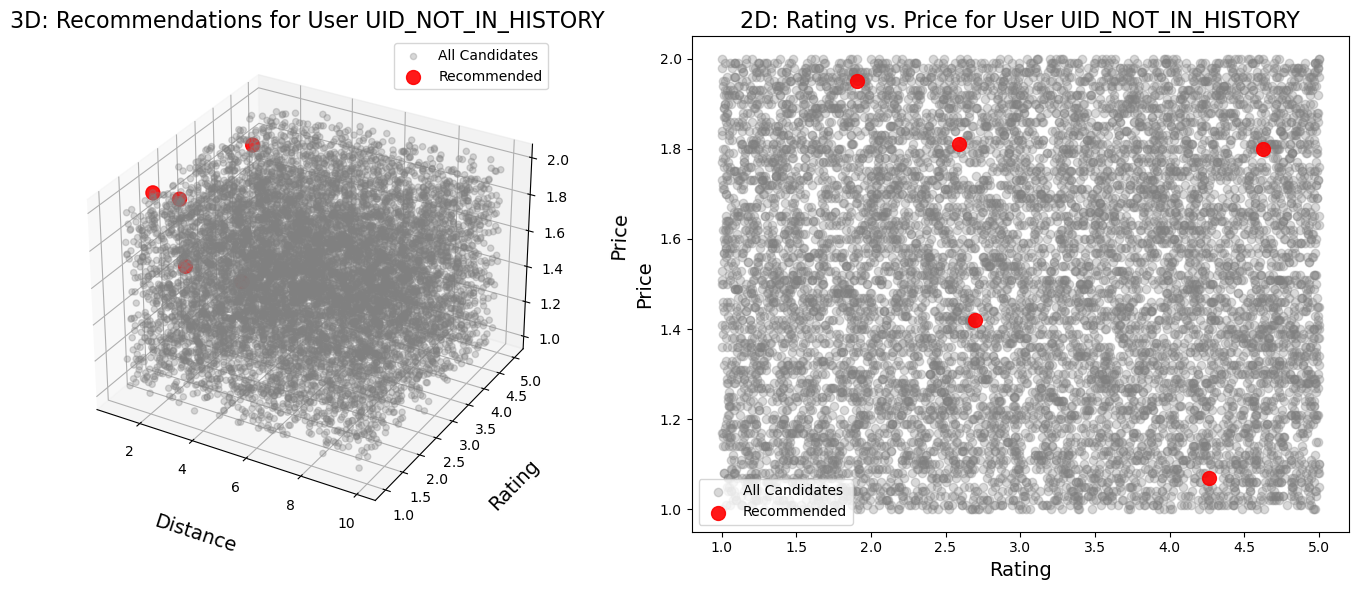


Processing visualizations for user: UID42085
User UID42085 (vector=[3.0, 1.3439305288632641, 72.75999999999999]) belongs to cluster: 2
Number of candidate parking spots in the same cluster: 10000


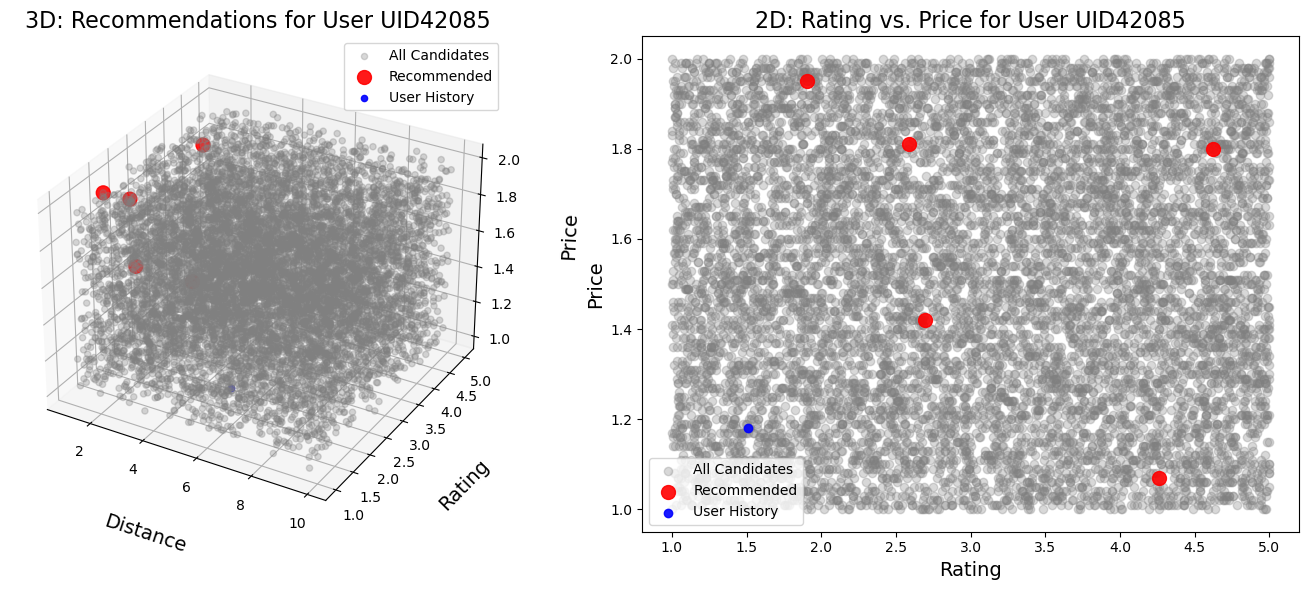


Processing visualizations for user: UID18737
User UID18737 (vector=[5.0, 1.5078610577265286, 239.7]) belongs to cluster: 1
Number of candidate parking spots in the same cluster: 0
No candidates found in the same cluster. Falling back to global nearest candidates.


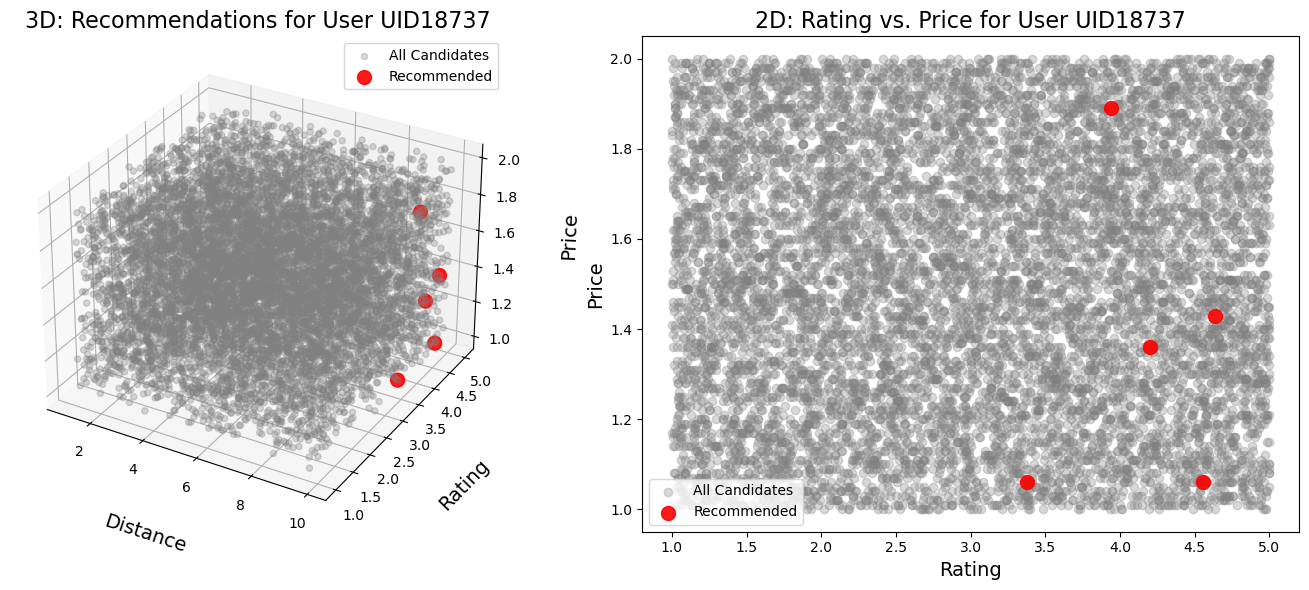


Processing visualizations for user: UID97023
User UID97023 (vector=[3.0, 1.7066666666666668, 82.62333333333333]) belongs to cluster: 2
Number of candidate parking spots in the same cluster: 10000


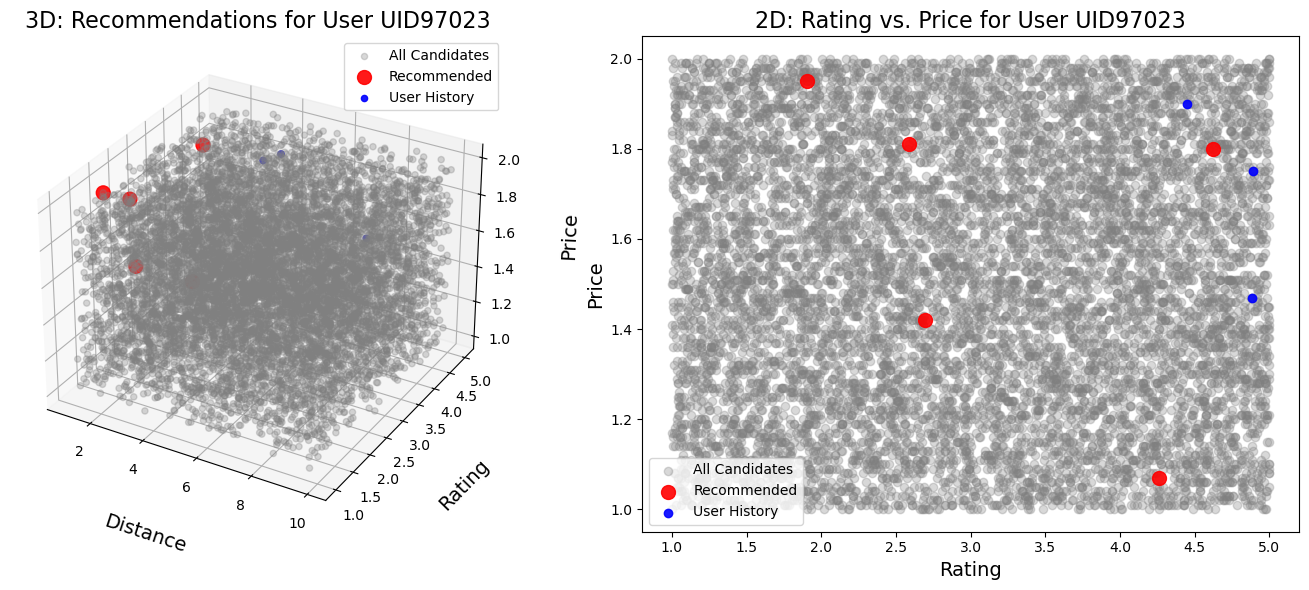

In [43]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from datetime import datetime
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# --- Load JSON Datasets ---
user_data = pd.read_json('user_data.json')
landlord_data = pd.read_json('landlord_data.json')
history_data = pd.read_json('history_data.json')
private_parking_data = pd.read_json('private_parking.json')
public_parking_data = pd.read_json('public_parking.json')

# --- Process History Data ---
# Merge history_data with private_parking_data to obtain price information.
merged_history = pd.merge(
    history_data,
    private_parking_data[['private_id', 'price_per_hour']],
    left_on='parking_id',
    right_on='private_id',
    how='left'
)
merged_history['price'] = merged_history['price_per_hour']

# Convert "distance" from a string like "40.78 KM" to a numeric value.
merged_history['distance'] = merged_history['distance'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)

# --- JSON Template for a Single Temporary Candidate Record ---
temp_data_template = {
    "user_id": "UIDXXXXXX",
    "parking_id": "PRI80775",
    "rating": 4.2,        # Estimated satisfaction score
    "price": 1.45,        # Current price per hour from parking data
    "distance": 3.2,      # Real-time computed distance (in km)
    "datetime": "2023-08-01T10:00:00"  # Time of parking search/request
}
with open('temp_data_template.json', 'w') as f:
    json.dump(temp_data_template, f, indent=4)

# --- Create Temporary Candidate Data from Private Parking Data ---
temp_data = private_parking_data.copy()
temp_data = temp_data.rename(columns={"private_id": "parking_id", "price_per_hour": "price"})
# If candidate data doesn't include rating, generate a random rating between 1 and 5.
if "rating" not in temp_data.columns:
    temp_data["rating"] = np.random.uniform(1, 5, size=len(temp_data))
# Generate a random distance for demonstration (in practice, compute using real coordinates).
temp_data["distance"] = np.random.uniform(1, 10, size=len(temp_data))
# Set current datetime for candidate records.
temp_data["datetime"] = datetime.now().isoformat()

# --- Function: Get User Preference Vector with Fake Data Fallback ---
def get_user_vector(user_id, history_df):
    """
    Returns the user preference vector as [avg_rating, avg_price, avg_distance].
    If the user has no history, randomly generates fake data within given thresholds.
    """
    user_history = history_df[history_df['user_id'] == user_id].copy()
    if not user_history.empty:
        # Fill missing values with global averages.
        global_avg_rating = history_df['rating'].mean()
        global_avg_price = history_df['price'].mean()
        global_avg_distance = history_df['distance'].mean()
        user_history['rating'].fillna(global_avg_rating, inplace=True)
        user_history['price'].fillna(global_avg_price, inplace=True)
        user_history['distance'].fillna(global_avg_distance, inplace=True)
        avg_rating = user_history['rating'].mean()
        avg_price = user_history['price'].mean()
        avg_distance = user_history['distance'].mean()
    else:
        print(f"No history available for user {user_id}. Generating fake history data.")
        # Fake data thresholds based on sample history:
        avg_rating = np.random.uniform(1, 5)
        avg_price = np.random.uniform(1.09, 1.88)
        avg_distance = np.random.uniform(36.01, 114.93)
    return np.array([[avg_rating, avg_price, avg_distance]])

# --- Function: Train KMeans on Historical Data ---
def train_kmeans_on_history(history_df, num_clusters=5):
    """
    Trains a KMeans model using features from the history data.
    Expected features: 'rating', 'price', 'distance'
    """
    features = history_df[['rating', 'price', 'distance']].copy()
    features['rating'] = pd.to_numeric(features['rating'], errors='coerce')
    features['price'] = pd.to_numeric(features['price'], errors='coerce')
    features['distance'] = pd.to_numeric(features['distance'], errors='coerce')
    features.fillna(features.mean(), inplace=True)
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(features.to_numpy())
    history_df['cluster'] = kmeans.labels_
    return kmeans

# --- Function: Recommend Parking Using Temporary Data ---
def recommend_parking_with_kmeans(user_id, history_df, temp_data_df, kmeans_model):
    """
    For a given user_id, uses their preference vector (or fake data if none exists)
    to determine a target cluster. Recommends candidate parking spots from temp_data_df
    that belong to that cluster. If none are found, falls back to the top 5 nearest candidates
    based on Euclidean distance.
    """
    user_vector = get_user_vector(user_id, history_df)
    user_cluster = kmeans_model.predict(user_vector)[0]
    print(f"User {user_id} (vector={user_vector.tolist()[0]}) belongs to cluster: {user_cluster}")
    
    # Assign clusters to candidate data.
    temp_features = temp_data_df[['rating', 'price', 'distance']].copy()
    predicted_clusters = kmeans_model.predict(temp_features.to_numpy())
    temp_data_df = temp_data_df.copy()  # Avoid SettingWithCopyWarning.
    temp_data_df['cluster'] = predicted_clusters
    
    # Select candidates in the same cluster.
    recommended = temp_data_df[temp_data_df['cluster'] == user_cluster].copy()
    print(f"Number of candidate parking spots in the same cluster: {len(recommended)}")
    
    # Fallback: If no candidates in that cluster, rank all candidates by Euclidean distance.
    if recommended.empty:
        print("No candidates found in the same cluster. Falling back to global nearest candidates.")
        diffs = temp_data_df[['rating', 'price', 'distance']] - user_vector
        dists = np.linalg.norm(diffs.to_numpy(), axis=1)
        temp_data_df['euclidean_distance'] = dists
        recommended = temp_data_df.sort_values('euclidean_distance').head(5)
    else:
        recommended = recommended.sort_values('distance').head(5)
    
    return recommended

# --- Visualization Function (3D and 2D) ---
def visualize_kmeans_recommendations(user_ids, history_df, candidate_df, kmeans_model):
    """
    For each user in user_ids, computes recommendations and visualizes:
      - A 3D scatter plot: Distance (x), Rating (y), Price (z)
      - A 2D scatter plot: Rating (x), Price (y)
    Recommended spots are highlighted in red, and user history (if available) in blue.
    """
    for user_id in user_ids:
        print(f"\nProcessing visualizations for user: {user_id}")
        recommendations = recommend_parking_with_kmeans(user_id, history_df, candidate_df, kmeans_model)
        if recommendations.empty:
            print(f"No recommendations available for user {user_id}")
            continue

        user_history = history_df[history_df["user_id"] == user_id]
        if not user_history.empty:
            # Match historical parking IDs with candidate data.
            history_candidates = candidate_df[candidate_df["parking_id"].isin(user_history["parking_id"])]
        else:
            history_candidates = pd.DataFrame()
        
        # --- 3D Plot ---
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(121, projection='3d')
        
        # Plot all candidates.
        ax.scatter(candidate_df["distance"], candidate_df["rating"], candidate_df["price"],
                   color="gray", label="All Candidates", alpha=0.3)
        # Plot recommended candidates.
        ax.scatter(recommendations["distance"], recommendations["rating"], recommendations["price"],
                   color="red", s=100, label="Recommended", alpha=0.9)
        # Plot user history (if available).
        if not history_candidates.empty:
            ax.scatter(history_candidates["distance"], history_candidates["rating"], history_candidates["price"],
                       color="blue", label="User History", alpha=0.9)
        
        ax.set_title(f"3D: Recommendations for User {user_id}", fontsize=16)
        ax.set_xlabel("Distance", labelpad=20, fontsize=14)
        ax.set_ylabel("Rating", labelpad=20, fontsize=14)
        ax.set_zlabel("Price", labelpad=20, fontsize=14)
        ax.legend()
        
        # --- 2D Plot (Rating vs. Price) ---
        ax2 = fig.add_subplot(122)
        ax2.scatter(candidate_df["rating"], candidate_df["price"], color="gray", label="All Candidates", alpha=0.3)
        ax2.scatter(recommendations["rating"], recommendations["price"], color="red", s=100, label="Recommended", alpha=0.9)
        if not history_candidates.empty:
            ax2.scatter(history_candidates["rating"], history_candidates["price"], color="blue", label="User History", alpha=0.9)
        
        ax2.set_title(f"2D: Rating vs. Price for User {user_id}", fontsize=16)
        ax2.set_xlabel("Rating", fontsize=14)
        ax2.set_ylabel("Price", fontsize=14)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

# --- Train the KMeans Model Using Processed Historical Data ---
kmeans_model = train_kmeans_on_history(merged_history, num_clusters=3)

# --- Specify a List of User IDs for Visualization (including one with no history) ---
user_ids_to_test = ["UID_NOT_IN_HISTORY", "UID42085","UID18737", "UID97023"]

# Ensure candidate_df has cluster labels.
candidate_df = temp_data.copy()
candidate_df['cluster'] = kmeans_model.predict(candidate_df[['rating', 'price', 'distance']].to_numpy())

# Visualize recommendations for these users.
visualize_kmeans_recommendations(user_ids_to_test, merged_history, candidate_df, kmeans_model)
